In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

Hello! GAN!


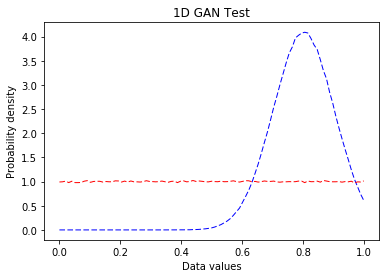

In [14]:
num_samples = 1000000

def main():
    print("Hello! GAN!")
    mu = 0.8
    sigma=0.1
    num_bins = 100
    x = np.random.normal(mu,sigma,num_samples)
    z = np.random.uniform(0,1,num_samples)
    
    bins = np.linspace(0,1,num_bins)
    px, _ = np.histogram(x,bins=bins, density = True)
    pz, _ = np.histogram(z,bins=bins, density = True)
    
    v = np.linspace(0,1,len(px))
    l = plt.plot(v,px,'b--',linewidth=1)
    l = plt.plot(v,pz,'r--',linewidth=1)
    plt.title('1D GAN Test')
    plt.xlabel('Data values')
    plt.ylabel('Probability density')
    plt.show()
    
main()